In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=8, size=(3, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

/home/alwin/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
z_dim = 256
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=32, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            #self.make_gen_block(hidden_dim * 2, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
GANdinsky = torch.load("models/gen.pt")
GANdinsky.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

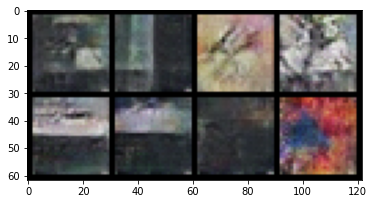

In [22]:
## generate some images
num_imgs = 8

image_tensor = GANdinsky(get_noise(num_imgs, z_dim))

show_tensor_images(image_tensor, num_imgs)